# Ch `13`: Concept `03`

Import the required libraries and data

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time

Import MNIST data

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


Parameters for training the Network

In [31]:
learning_rate = 0.001
training_epochs = 200
batch_size = 1000
display_step = 1
examples_to_show = 10

# Network Parameters
# Hidden units are more than the input dimensionality since the intention
# is to learn sparse representation of hidden units
n_hidden_1 = 32*32
n_input = 784 # MNIST data input (img shape: 28*28)
X = tf.placeholder("float", [None, n_input])
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b1': tf.Variable(tf.random_normal([n_input])),
}

Building the encoder

In [32]:
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    return layer_1


Building the decoder

In [36]:
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, tf.transpose(weights['encoder_h1'])), \
                                   biases['decoder_b1']))
    return layer_1

Define the log-based function to be used in computing the KL Divergence

In [37]:
def log_func(x1, x2):
    return tf.multiply(x1, tf.log(tf.div(x1,x2)))

def KL_Div(rho, rho_hat):
    inv_rho = tf.subtract(tf.constant(1.), rho)
    inv_rhohat = tf.subtract(tf.constant(1.), rho_hat)
    log_rho = log_func(rho,rho_hat) + log_func(inv_rho, inv_rhohat)
    return log_rho

Model definition

In [38]:
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
rho_hat = tf.reduce_mean(encoder_op,1)

Reconstructed output

In [39]:
y_pred = decoder_op
y_true = X
# Define the TensorFlow Ops for loss and optimizer, minimize the combined error
# Squared Reconstruction error
cost_m = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
# KL Divergence Regularization to introduce sparsity
cost_sparse = 0.001*tf.reduce_sum(KL_Div(0.2,rho_hat))
# L2 Regularization of weights to keep the network stable
cost_reg = 0.0001* (tf.nn.l2_loss(weights['decoder_h1']) + tf.nn.l2_loss(weights
['encoder_h1']))
# Add up the costs
cost = tf.add(cost_reg,tf.add(cost_m,cost_sparse))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)
# Initializing the variables
init = tf.global_variables_initializer()

Launch the Session graph

Epoch: 0001 cost= 80.858047485
Epoch: 0002 cost= 80.765884399
Epoch: 0003 cost= 79.268035889
Epoch: 0004 cost= 73.489753723
Epoch: 0005 cost= 67.169189453
Epoch: 0006 cost= 61.276992798
Epoch: 0007 cost= 55.802894592
Epoch: 0008 cost= 50.727928162
Epoch: 0009 cost= 46.028846741
Epoch: 0010 cost= 41.691268921
Epoch: 0011 cost= 37.693141937
Epoch: 0012 cost= 34.015552521
Epoch: 0013 cost= 30.640348434
Epoch: 0014 cost= 27.547897339
Epoch: 0015 cost= 24.723182678
Epoch: 0016 cost= 22.143636703
Epoch: 0017 cost= 19.795804977
Epoch: 0018 cost= 17.662178040
Epoch: 0019 cost= 15.727974892
Epoch: 0020 cost= 13.977905273
Epoch: 0021 cost= 12.398056030
Epoch: 0022 cost= 10.974398613
Epoch: 0023 cost= 9.693997383
Epoch: 0024 cost= 8.546010971
Epoch: 0025 cost= 7.517593384
Epoch: 0026 cost= 6.599705696
Epoch: 0027 cost= 5.781756401
Epoch: 0028 cost= 5.055027485
Epoch: 0029 cost= 4.410412312
Epoch: 0030 cost= 3.840119123
Epoch: 0031 cost= 3.337361336
Epoch: 0032 cost= 2.894100666
Epoch: 0033 cost= 

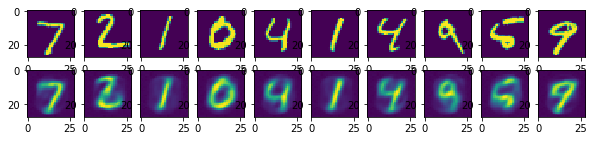

In [40]:
start_time = time.time()
with tf.Session() as sess:
    sess.run(init)
    total_batch = int(mnist.train.num_examples/batch_size)
    for epoch in range(training_epochs):
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs})
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1),
                  "cost=", "{:.9f}".format(c))
    print("Optimization Finished!")
    # Applying encode and decode over test set
    encode_decode = sess.run(
        y_pred, feed_dict={X: mnist.test.images[:10]})
    # Compare original images with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(10):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    # Store the Decoder and Encoder Weights
    dec = sess.run(weights['decoder_h1'])
    enc = sess.run(weights['encoder_h1'])
end_time = time.time()
print('elapsed time:',end_time - start_time)